In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.metrics import classification_report, accuracy_score
from torch.optim.lr_scheduler import StepLR

from utils.DataUtils import DataUtils
from utils.GloveUtils import GloveUtils

In [10]:
# Load split data
yahoo_train = pd.read_csv("./data/yahoo_train.csv")
yahoo_test = pd.read_csv("./data/yahoo_test.csv")

# Initialize custom util library
utils = DataUtils()

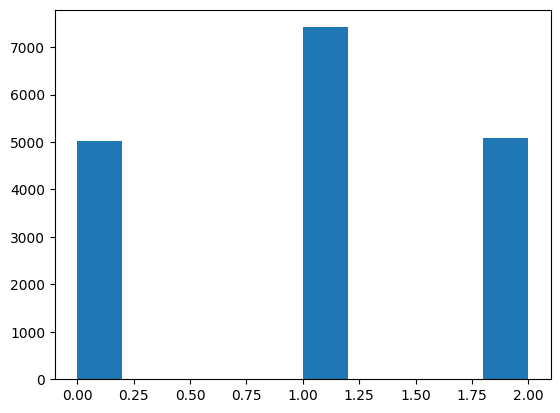

In [4]:
_ = plt.hist(yahoo_train['label'])

Parse, tokenize, and lemmatize

In [12]:
yahoo_train['clean_txt'] = utils.clean_data(yahoo_train['text'], max_words=40)
yahoo_test['clean_txt'] = utils.clean_data(yahoo_test['text'], max_words=40)

In [13]:
GLOVE_PATH = "./data/glove.6B.100d.txt"
glove_utils = GloveUtils(GLOVE_PATH, max_dims=64)

glove_emb_layer = glove_utils.create_glove_emb_layer(trainable=True)
train_emb_ids = glove_utils.get_embedding_indices(yahoo_train['clean_txt'])
test_emb_ids = glove_utils.get_embedding_indices(yahoo_test['clean_txt'])

Glove Embedding shape: (400000, 100)


In [14]:
import torch

print(f'CUDA: {torch.cuda.is_available()}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {device}')
torch.cuda.empty_cache()

CUDA: True
DEVICE: cuda:0


In [15]:
train_emb_ids = train_emb_ids.to(device)
test_emb_ids = test_emb_ids.to(device)

y_train = torch.Tensor(np.asarray(yahoo_train['label'], dtype=np.uint8)).to(device)
y_test = torch.Tensor(np.asarray(yahoo_test['label'], dtype=np.uint8)).to(device)

In [16]:
print(f'X: {train_emb_ids.shape}')
print(f'y: {y_train.shape}')

X: torch.Size([17522, 64])
y: torch.Size([17522])


In [17]:
# Finally Embedding layer to the GPU
glove_emb_layer = glove_emb_layer.to(device)

_, cts = np.unique(torch.Tensor.cpu(y_train), return_counts=True)
class_weights = 1.0 / cts
class_weights /= class_weights.sum()
print(class_weights)
class_weights = torch.Tensor(class_weights).to(device)

[0.37492539 0.25406162 0.371013  ]


In [18]:
BATCH_SIZE = 8192
NUM_LABELS = 3
MAX_WORDS = 40

def setup_model(num_classes=NUM_LABELS, emb_layer=glove_emb_layer):
    return nn.Sequential(
        emb_layer,
        nn.Flatten(),
        nn.Linear(64 * 100, 2048),
        nn.Dropout(0.3),
        nn.LeakyReLU(),
        nn.Linear(2048, 512),
        nn.Dropout(0.3),
        nn.LeakyReLU(),
        nn.Linear(512, 64),
        nn.LeakyReLU(),
        nn.Linear(64, num_classes),
        nn.Softmax(dim=1)
    )

In [19]:
def train_model(model, X_train, X_test, y_train, y_test, n_epochs=50, lr=0.001):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
    batch_per_epoch = len(X_train) // BATCH_SIZE

    tr_loss_hist = np.zeros((n_epochs,), dtype=np.float32)
    ts_loss_hist = np.zeros((n_epochs,), dtype=np.float32)
    ts_acc_hist = np.zeros((n_epochs), dtype=np.float32)

    for epoch in range(n_epochs):
        print(f'*** EPOCH {epoch} ***')
        print(f'lr: {scheduler.get_last_lr()[0]}')
        tr_loss = 0.
        model.train(mode=True)
        for i in range(batch_per_epoch):
            st = i * BATCH_SIZE
            X_batch = X_train[st:st + BATCH_SIZE]
            y_batch = y_train[st:st + BATCH_SIZE]
            # Reset gradients
            optimizer.zero_grad()
            
            # predict / forward pass
            y_logits = model(X_batch)
            loss = loss_fn(y_logits, y_batch.to(torch.uint8))
            tr_loss += loss
            # tune / backward pass
            loss.backward()
            
            # update weights
            optimizer.step()
        scheduler.step()
        tr_loss /= batch_per_epoch
        optimizer.zero_grad()
        # test
        with torch.no_grad():
            y_pred_logits = model(X_test)
            acc = accuracy_score(torch.Tensor.cpu(y_test), np.argmax(torch.Tensor.cpu(y_pred_logits), axis=1))
            test_loss = loss_fn(y_pred_logits, y_test.to(torch.uint8))
        
        print("Train Loss {:.2f}".format(tr_loss))
        print("Test Loss {:.2f}".format(test_loss))
        print("Test Accuracy {:.2f} \n".format(acc))
        tr_loss_hist[epoch] = tr_loss
        ts_loss_hist[epoch] = test_loss
        ts_acc_hist[epoch] = acc
    return tr_loss_hist, ts_loss_hist, ts_acc_hist

In [20]:
model = setup_model(num_classes=NUM_LABELS)
model = model.to(device)
print(model)

Sequential(
  (0): Embedding(400000, 100)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=6400, out_features=2048, bias=True)
  (3): Dropout(p=0.3, inplace=False)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=2048, out_features=512, bias=True)
  (6): Dropout(p=0.3, inplace=False)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=512, out_features=64, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=64, out_features=3, bias=True)
  (11): Softmax(dim=1)
)


In [21]:
tr_loss_hist, ts_loss_hist, ts_acc_hist = train_model(model, train_emb_ids, test_emb_ids, y_train, y_test, n_epochs=300)

*** EPOCH 0 ***
lr: 0.001
Train Loss 1.11
Test Loss 1.09
Test Accuracy 0.41 

*** EPOCH 1 ***
lr: 0.001
Train Loss 1.08
Test Loss 1.07
Test Accuracy 0.42 

*** EPOCH 2 ***
lr: 0.001
Train Loss 1.07
Test Loss 1.06
Test Accuracy 0.44 

*** EPOCH 3 ***
lr: 0.001
Train Loss 1.06
Test Loss 1.06
Test Accuracy 0.44 

*** EPOCH 4 ***
lr: 0.001
Train Loss 1.05
Test Loss 1.05
Test Accuracy 0.45 

*** EPOCH 5 ***
lr: 0.001
Train Loss 1.05
Test Loss 1.04
Test Accuracy 0.47 

*** EPOCH 6 ***
lr: 0.001
Train Loss 1.03
Test Loss 1.03
Test Accuracy 0.49 

*** EPOCH 7 ***
lr: 0.001
Train Loss 1.01
Test Loss 1.02
Test Accuracy 0.49 

*** EPOCH 8 ***
lr: 0.001
Train Loss 1.00
Test Loss 0.99
Test Accuracy 0.52 

*** EPOCH 9 ***
lr: 0.001
Train Loss 0.98
Test Loss 0.99
Test Accuracy 0.52 

*** EPOCH 10 ***
lr: 0.001
Train Loss 0.98
Test Loss 0.97
Test Accuracy 0.54 

*** EPOCH 11 ***
lr: 0.001
Train Loss 0.96
Test Loss 0.97
Test Accuracy 0.54 

*** EPOCH 12 ***
lr: 0.001
Train Loss 0.96
Test Loss 0.97
Test

In [22]:
MODEL_NAME = "yahoo_2048_final_ep_300"
torch.save(model, f"./models/{MODEL_NAME}")

In [23]:
training_hist = pd.DataFrame.from_dict({'train_loss': tr_loss_hist, 'test_loss': ts_loss_hist, 'accuracy': ts_acc_hist})
training_hist.to_csv(f'./models/{MODEL_NAME + '_training_history'}.csv')

In [24]:
with torch.no_grad():
    y_pred = np.argmax(torch.Tensor.cpu(model(test_emb_ids)), axis=1)
    print(classification_report(torch.Tensor.cpu(y_test), y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.66      0.66      2204
         1.0       0.81      0.81      0.81      3167
         2.0       0.68      0.70      0.69      2139

    accuracy                           0.73      7510
   macro avg       0.72      0.72      0.72      7510
weighted avg       0.73      0.73      0.73      7510
